In [145]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [110]:
california_house_data = load_breast_cancer()

In [111]:
X = california_house_data['data']
y = california_house_data['target']

## Simple Logistic Regression

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [181]:
clf = Pipeline([('scaler', StandardScaler()), ('log_reg', LogisticRegression())])

In [182]:
clf.fit(X_train, y_train);

In [183]:
y_preds = clf.predict(X_test)
print(classification_report(y_test, y_preds))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99        99
          1       0.99      1.00      0.99       186

avg / total       0.99      0.99      0.99       285



In [184]:
y_probs = clf.predict_proba(X_test)[:, 1]
orig_auc = roc_auc_score(y_test, y_probs)
print("Original AUC:", orig_auc)

Original AUC: 0.995981318562


## 1) Coefficients

### a) Feature Correlations

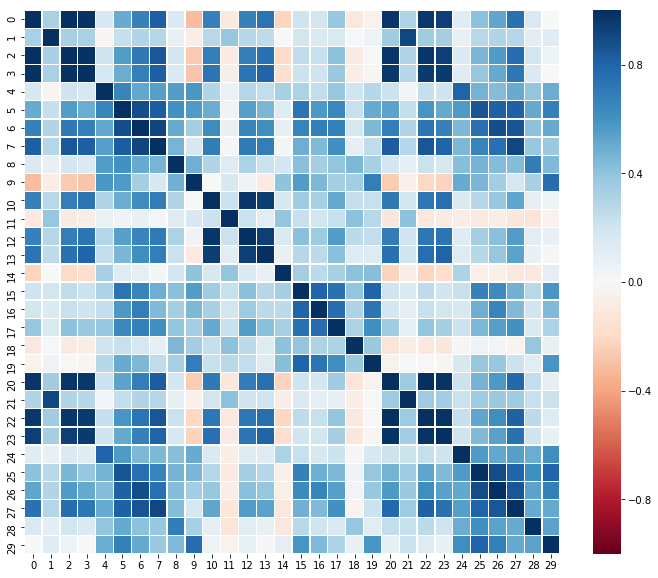

In [119]:
correlation_matrix = np.corrcoef(X, rowvar=0)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, linewidths=0.25, ax=ax, cmap=cm.RdBu, vmin=-1., vmax=1.);

In [185]:
lr_coefs = clf.named_steps['log_reg'].coef_[0]

In [186]:
feature_rank_coef = np.argsort(np.abs(lr_coefs))[::-1]

In [187]:
feature_rank_coef

array([10, 27,  7, 13, 24, 26, 28,  6, 19,  1, 21, 20, 23, 12, 22, 15, 29,
        9,  5,  4,  3, 14, 16,  0,  2, 17, 25, 11, 18,  8])

## 2) Remove one and measure

In [188]:
delta_auc = []
for i in range(X.shape[1]):
    clf = Pipeline([('scaler', StandardScaler()), ('log_reg', LogisticRegression())])
    X_train_new = np.delete(X_train, i, axis=1)
    X_test_new = np.delete(X_test, i, axis=1)
    clf.fit(X_train_new, y_train)
    y_probs = clf.predict_proba(X_test_new)[:, 1]
    auc_without_ith_feature = roc_auc_score(y_test, y_probs)
    delta_auc.append(orig_auc - auc_without_ith_feature)

In [189]:
feature_rank_delta = np.argsort(delta_auc)[::-1]

In [190]:
feature_rank_delta

array([21, 28,  9, 20, 23, 22,  5, 17,  4, 18,  8,  6,  3,  2,  0, 25, 16,
       15, 13, 29, 27, 26, 11, 10, 12,  7,  1, 19, 24, 14])

## 3) Univariate Analysis

In [191]:
feature_rank_mi = np.argsort(mutual_info_classif(X, y))[::-1]

In [192]:
feature_rank_mi

array([22, 23, 20,  7, 27,  2,  6,  0,  3, 13, 26, 12, 10, 25,  5, 17, 21,
       16, 24,  1, 28,  4, 15, 29,  8, 19, 14, 18,  9, 11])

## Test ranks

In [198]:
def auc_for_k_best(X_train, X_test, y_train, y_test, feature_rank):
    aucs = []
    for i in range(len(feature_rank)):
        features_index = feature_rank[:i + 1]
        X_train_limited = X_train[:, features_index]
        X_test_limited = X_test[:, features_index]
        clf = Pipeline([('scaler', StandardScaler()), ('log_reg', LogisticRegression())])
        clf.fit(X_train_limited, y_train)
        y_probs = clf.predict_proba(X_test_limited)[:, 1]
        aucs.append(roc_auc_score(y_test, y_probs))
    return aucs


def plot_auc_curve_for_rank(X_train, X_test, y_train, y_test, feature_ranks):
    fig, ax = plt.subplots(figsize=(16, 9))
    for method, feature_rank in feature_ranks.items():
        auc_scores = auc_for_k_best(X_train, X_test, y_train, y_test, feature_rank)
        ax.plot(np.arange(len(feature_rank)), auc_scores, 'o--', mew=0., alpha=0.75, label=method)
    ax.axhline(y=1.0, color='k', linestyle='--')
    ax.set_xlabel(r"k best features used", fontsize=20)
    ax.set_ylabel(r"AUC score", fontsize=20)
    ax.legend(loc='lower right', frameon=False, fontsize=20)
    return fig

In [194]:
feature_ranks = {
    'Coefficients': feature_rank_coef,
    'Metric Delta': feature_rank_delta,
    'Mutual Information': feature_rank_mi
}

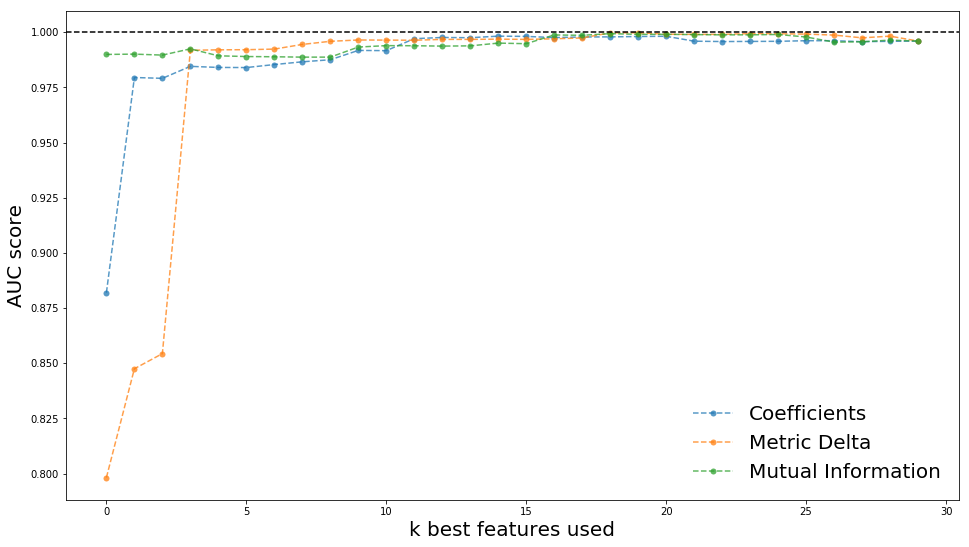

In [199]:
plot_auc_curve_for_rank(X_train, X_test, y_train, y_test, feature_ranks);